# 6.基因聚类与KEGG

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
subsample_adata = scv.read("./data/subsample_adata.h5ad") # 额外读取
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
subsample_adata, adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


(AnnData object with n_obs × n_vars = 4907 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
     uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
     obsm: 'X_pca', 'X_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovgi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
     var: 'Acces

## 2. 基因聚类

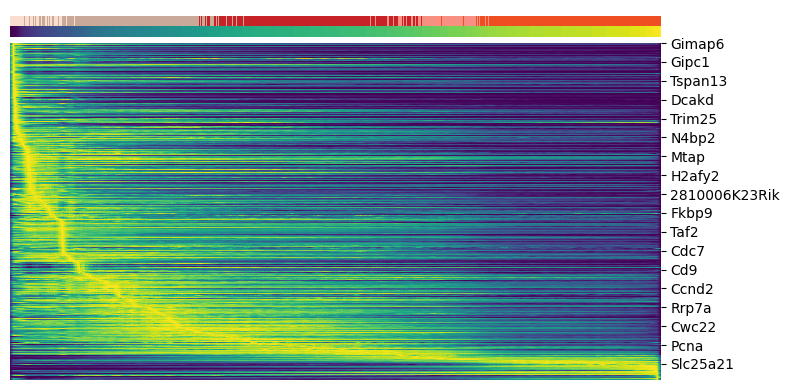

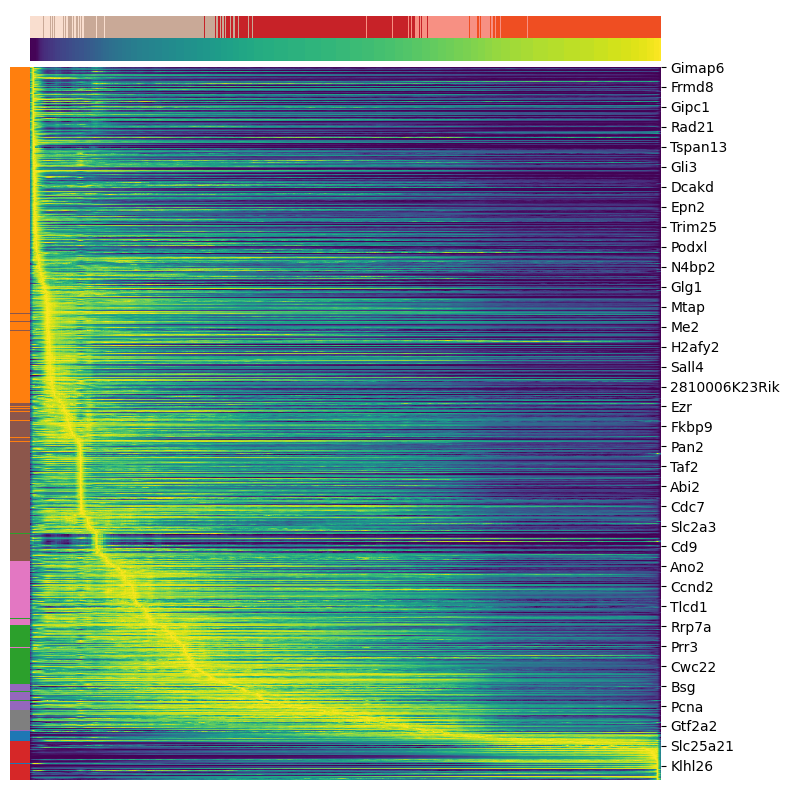

In [3]:
# 使用转换后的结果进行基因聚类
import seaborn as sns
from sklearn.cluster import KMeans

top_genes = list(adata.var.index[:2000])
cm = scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", sort=True, col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, show=False) # 同时保存clustermap的网格对象，发布概念后续的聚类

# 构建特征，这里不是直接用表达矩阵作为特征，而是使用高表达的前n个时间点构建特征矩阵
n = 5 # 高表达的前几个时刻
df = cm.data2d # 这里提取出clustermap的结果
A = df.values.argsort()[:, -n:]

# 执行聚类
k = 8 # 聚类个数
classifier = KMeans(n_clusters=k, random_state=0).fit(A)
gene_cluster_list = classifier.labels_

# 颜色转换
color_dict = dict(enumerate(sns.palettes.color_palette()[:k])) # 10个色系一般够用了
color_list = list(map(lambda x: color_dict[x], gene_cluster_list))

scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, row_colors = color_list, figsize=(8,8)) 

## 3. 基因聚类的平均值变化情况

([], [])

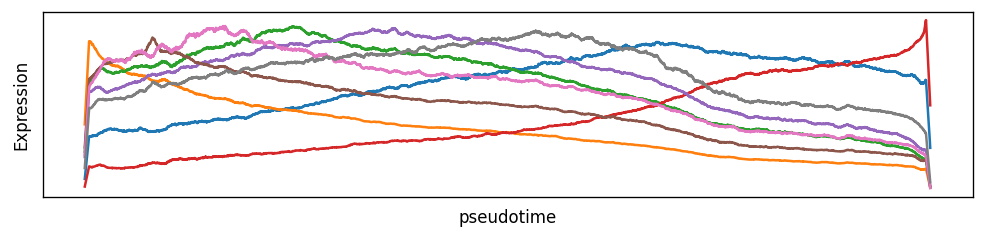

In [4]:
import matplotlib.pyplot as plt

A = df
A["gene_cluster"] = gene_cluster_list # 添加最后一列
mean_df = A.groupby("gene_cluster").mean().T # 每类基因的均值

plt.figure(figsize=(10, 2), dpi=120)

for i in range(k):
    plt.plot(mean_df[i], color=color_dict[i])

plt.xlabel("pseudotime")
plt.xticks([])
plt.ylabel("Expression")
plt.yticks([])

## 4. KEGG富集成表格

In [5]:
# 抽取各个聚类的基因名列表
gene_list_dict = {}
for i in range(k):
    gene_list = list(adata.var.index[gene_cluster_list==i])
    gene_list_dict[i] = gene_list

In [6]:
import os
import pandas as pd
import gseapy as gp

mode = "KEGG" # 选择使用kegg或者go进行富集分析

# 根据模式选择保存路径
kegg_parent_dir = "./kegg"
go_parent_dir = "./go"
if mode == "kegg" or mode == "KEGG":
    print("执行KEGG富集分析")
    parent_dir = kegg_parent_dir
else:
    print("执行GO富集分析")
    parent_dir = go_parent_dir
if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)
img_dir = "%s/img"%parent_dir
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
dataframe_dir = "%s/dataframe"%parent_dir
if not os.path.exists(dataframe_dir):
    os.mkdir(dataframe_dir)


# 富集分析的一些参数
cmap = plt.cm.autumn_r
cutoff = 1

# 对各个基因聚类富集分析
enrichment_df_dict = {}
for i in gene_list_dict.keys():
    title = "Clusters%d"%i
    print(title)
    gene_list = gene_list_dict[i]
    if mode == "kegg" or mode == "KEGG":
        enrichment_df = gp.enrichr(gene_list, gene_sets="KEGG_2019_Mouse").res2d # kegg只需要搜索1个数据库即可
        enrichment_df.to_csv("%s/%s.csv"%(dataframe_dir, title)) # 保存DataFrame
        gp.dotplot(enrichment_df, figsize=(3,5), title=title, cmap = cmap, cutoff=cutoff, ofname="%s/%s.pdf"%(img_dir, title)) # 保存kegg结果图
    else:
        bp_df = gp.enrichr(gene_list, gene_sets="GO_Biological_Process_2021").res2d # go需要搜索3个
        cc_df = gp.enrichr(gene_list, gene_sets="GO_Cellular_Component_2021").res2d
        mf_df = gp.enrichr(gene_list, gene_sets="GO_Molecular_Function_2021").res2d
        bp_df["label"] = "Biological_Process"
        cc_df["label"] = "Cellular_Component"
        mf_df["label"] = "Molecular_Function"
        bp_df.to_csv("%s/%s_bp.csv"%(dataframe_dir, title))  # 分别保存DataFrame
        cc_df.to_csv("%s/%s_cc.csv"%(dataframe_dir, title)) 
        mf_df.to_csv("%s/%s_mf.csv"%(dataframe_dir, title)) 
        gp.dotplot(bp_df, figsize=(3,5), title="%s_bp"%title, cmap = cmap, cutoff=cutoff, ofname="%s/%s_bp.pdf"%(img_dir, title)) # 分别保存GO结果图
        gp.dotplot(cc_df, figsize=(3,5), title="%s_cc"%title, cmap = cmap, cutoff=cutoff, ofname="%s/%s_gp.pdf"%(img_dir, title))
        gp.dotplot(mf_df, figsize=(3,5), title="%s_mf"%title, cmap = cmap, cutoff=cutoff, ofname="%s/%s_mf.pdf"%(img_dir, title))
        enrichment_df = pd.concat([bp_df, cc_df, mf_df]) # 保存DataFrame
        enrichment_df.to_csv("%s/%s.csv"%(dataframe_dir, title))
        gp.dotplot(enrichment_df,figsize=(10,12), cutoff=1, x="label",
                  x_order=["Biological_Process", "Cellular_Component", "Molecular_Function"],
                  title=title, top_term=5, show_ring=True, ofname="%s/%s.pdf"%(img_dir, title)) # 保存GO结果图
    enrichment_df_dict[i] = enrichment_df # 方便后续查看

执行KEGG富集分析
Clusters0
Clusters1
Clusters2
Clusters3
Clusters4
Clusters5
Clusters6
Clusters7


In [7]:
# 手动指定一些通路
# pathway_list = [
#     "RNA transport",
#     "Cell cycle",
#     "Ribosome",
#     "Homologous recombination",
#     "Ribosome",
# ]
pathway_list = ['Pathways in cancer',
 'p53 signaling pathway',
 'Cell cycle',
 'Regulation of actin cytoskeleton',
 'PI3K-Akt signaling pathway',
 'Focal adhesion',
 'Nitrogen metabolism',
 'Adherens junction',
 'MicroRNAs in cancer',
 'Tight junction',
 'ECM-receptor interaction',
 'Axon guidance']

Text(53.66666666666665, 0.5, 'Erichment Item')

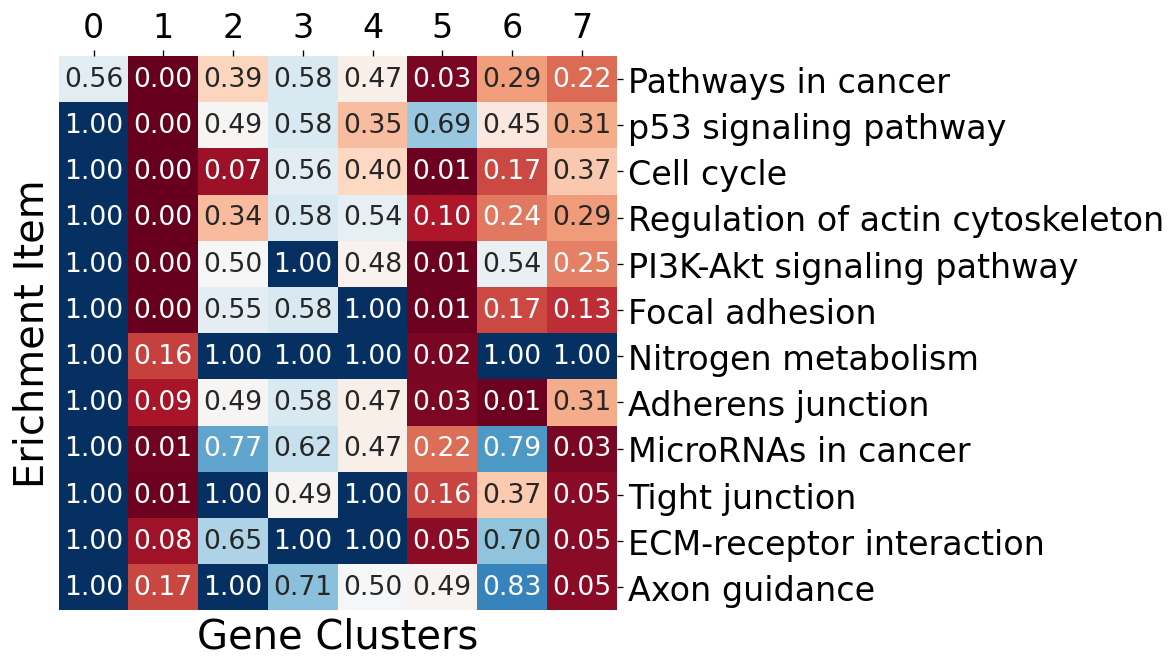

In [8]:
import numpy as np

plt.figure(figsize=(6,6), dpi=120)
df = pd.DataFrame(np.ones((k, len(pathway_list))), columns=pathway_list)

for i in enrichment_df_dict.keys():
    kegg_df = enrichment_df_dict[i]
    for pathway in pathway_list:
        if pathway in list(kegg_df["Term"]):
            pvalue = float(kegg_df[kegg_df["Term"] == pathway]["Adjusted P-value"])
            df.loc[i,pathway] = pvalue # 有该通路则更新值

# 表格还需要美化
ax = sns.heatmap(df.T, annot=True, fmt=".2f", cbar=False, cmap="RdBu", annot_kws={"fontsize":16}, )

ax.xaxis.set_ticks_position("top") 
ax.yaxis.set_ticks_position("right") 
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)

plt.xlabel("Gene Clusters", fontsize=24)
plt.ylabel("Erichment Item", fontsize=24)

## 5. 色带绘制

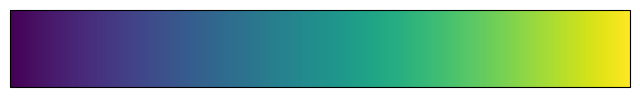

In [9]:
import matplotlib as mpl

# 基因表达随时间变化色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# 干脆文字部分都不要了
cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)

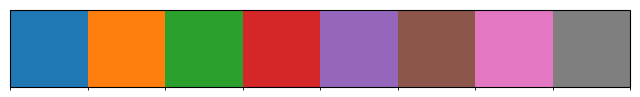

In [10]:
# 基因聚类色带
colors = color_dict.values()
fig, ax = plt.subplots(figsize=(8, 1))
cmap = mpl.colors.ListedColormap(colors) # 指定离散颜色
bounds = range(len(colors)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[]
)

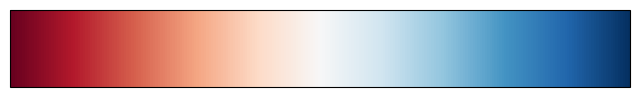

In [11]:
# 显著性色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)